In [29]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import exowrap
from exowrap.output import ExoremOut
from exowrap.tools import upgrade_resolution
from exowrap.photometry import get_svo_filter, compute_photometry
from exowrap.plotting import plot_model_summary


# 1. Define standard test parameters
params = {
    "mass": 1.0,
    "T_int": 500,
    "T_irr": 0.0,
    "Met": 0.0,
    "f_sed": 2.0,
    "kzz": 8.0,
    "g_1bar": 10.0
}

# 2. Run the FAST R=50 model to converge the P-T profile
print("Running fast R=50 simulation to converge the P-T profile... ⏳")
model_50 = exowrap.Simulation(params=params, resolution=50)
df_50 = model_50.run()

print("✅ P-T profile converged!")

INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpfqmyzxz5/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...


Running fast R=50 simulation to converge the P-T profile... ⏳


INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpfqmyzxz5/outputs/exowrap_run.h5...
INFO: Simulation complete.


✅ P-T profile converged!


INFO: Starting ExoREM Simulation...
INFO: Generated namelist at /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpvj43gfk_/input.nml
INFO: Running Fortran backend from /Users/cwilkinson/.exowrap/exorem_source/dist/dist/exorem/bin...


Upgrading to R=500 for precise photometry... ⚡
🚀 Upgrading simulation to R=500...
💾 Locked P-T profile saved to: ../data/high_res_spectra/locked_pt_profile.dat
⚡ Executing 0-iteration forward pass...


INFO: Parsing results from /private/var/folders/ld/pl_0zzs158sb8h6_y3mrd0lm0000gp/T/tmpvj43gfk_/outputs/exowrap_run.h5...
INFO: 💾 Permanently saved HDF5 to: ../data/high_res_spectra/exorem_Tint500_g10.0.h5
INFO: Simulation complete.


🎉 High-resolution upgrade complete!
✅ High-resolution spectrum ready!


(<Figure size 1200x900 with 4 Axes>,
 array([[<Axes: >,
         <Axes: xlabel='Temperature (K)', ylabel='Pressure (bar)'>],
        [<Axes: title={'center': 'Stellar Flux'}, xlabel='$\\lambda\\ \\mathrm{(\\mu m)}$', ylabel='$F_{\\lambda}\\ \\mathrm{(W\\ m^{-2}\\ \\mu m^{-1})}$'>,
         <Axes: title={'center': 'Transmission'}, xlabel='$\\lambda\\ \\mathrm{(\\mu m)}$', ylabel='$D_{\\mathrm{tr}}\\ \\mathrm{(-)}$'>]],
       dtype=object))

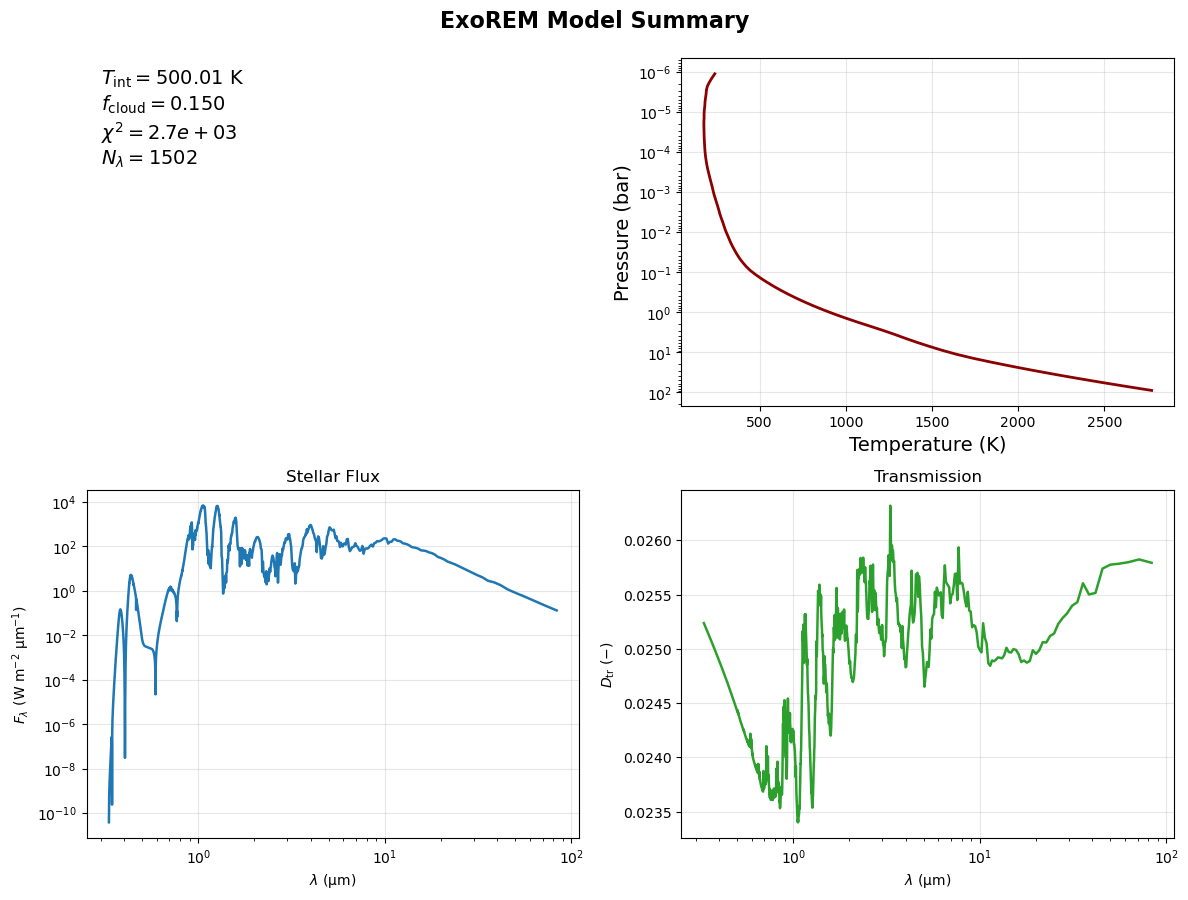

In [31]:
print("Upgrading to R=500 for precise photometry... ⚡")

# Instantly upgrade the resolution
df_500 = upgrade_resolution(
    results=df_50, 
    base_params=params, 
    target_resolution=500
)

# Wrap the new high-res dataframe
exo_data = ExoremOut(df_500)
print("✅ High-resolution spectrum ready!")

plot_model_summary(ExoremOut(df_500))

In [32]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import exowrap
from exowrap.output import ExoremOut
from exowrap.tools import upgrade_resolution, load_exorem_h5
from exowrap.photometry import get_svo_filter, compute_photometry
from exowrap.plotting import plot_model_summary

# 1. Define the path to your saved high-res model
h5_path = "../data/high_res_spectra/exorem_Tint500_g10.0.h5"

print(f"Loading {h5_path} into memory... ⏳")

# 2. Load it and wrap it!
df_loaded = load_exorem_h5(h5_path)
exo_data = ExoremOut(df_loaded)

print(f"✅ Successfully loaded! Found {len(exo_data.wavelength)} spectral points.")

Loading ../data/high_res_spectra/exorem_Tint500_g10.0.h5 into memory... ⏳
✅ Successfully loaded! Found 1502 spectral points.


In [33]:
import exowrap
from exowrap.photometry import search_svo_filters

# Want to see all JWST filters?
jwst_filters = search_svo_filters("JWST")
print(f"Found {len(jwst_filters)} JWST filters! Here are the first 5:")
print(jwst_filters[:5])

# Want to see all 2MASS filters?
twomass_filters = search_svo_filters("2MASS")
print(f"\nFound {len(twomass_filters)} 2MASS filters:")
print(twomass_filters)

Found 88 JWST filters! Here are the first 5:
['JWST/MIRI.F1000W', 'JWST/MIRI.F1065C', 'JWST/MIRI.F1130W', 'JWST/MIRI.F1140C', 'JWST/MIRI.F1280W']

Found 3 2MASS filters:
['2MASS/2MASS.H', '2MASS/2MASS.J', '2MASS/2MASS.Ks']


In [34]:
# Test the raw filter download function
filter_name = "2MASS/2MASS.Ks"
print(f"Downloading {filter_name} from SVO FPS...")

wav_um, trans = get_svo_filter(filter_name)

print(f"Successfully downloaded {len(wav_um)} data points.")
print(f"Filter range: {wav_um.min():.2f} μm to {wav_um.max():.2f} μm")
print(f"Peak Transmission: {trans.max() * 100:.1f}%")

Successfully downloaded 76 data points.
Filter range: 1.90 μm to 2.40 μm
Peak Transmission: 100.0%


In [35]:
# Define the filters we want to test
filters_to_test = [
    "2MASS/2MASS.J",
    "2MASS/2MASS.H",
    "2MASS/2MASS.Ks"
]

photometric_results = []

print("Computing synthetic photometry...")
for fid in filters_to_test:
    # This automatically downloads the filter, interpolates it, and integrates the flux!
    result = compute_photometry(exo_data, filter_id=fid)
    photometric_results.append(result)
    
    print(f"[{fid}]")
    print(f"  Effective Wavelength: {result['effective_wavelength_um']:.3f} μm")
    print(f"  Integrated Flux:      {result['flux_Jy']:.4e} Jy\n")

Computing synthetic photometry...
[2MASS/2MASS.J]
  Effective Wavelength: 1.241 μm
  Integrated Flux:      9.9933e+14 Jy

[2MASS/2MASS.H]
  Effective Wavelength: 1.651 μm
  Integrated Flux:      3.8629e+14 Jy

[2MASS/2MASS.Ks]
  Effective Wavelength: 2.166 μm
  Integrated Flux:      1.5930e+14 Jy



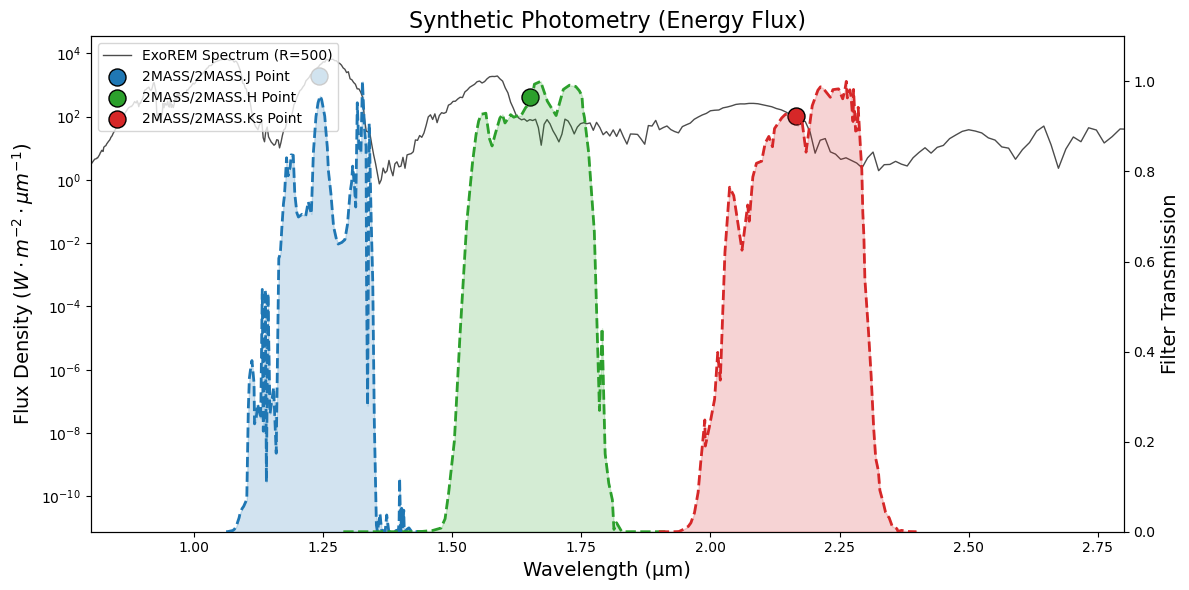

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---------------------------------------------------
# AXIS 1 (Left): The ExoREM Spectrum in W/m^2/um
# ---------------------------------------------------
# Extract valid wavelengths and our F_lambda flux property
wl = exo_data.wavelength
valid = wl > 0
wl_valid = wl[valid]
flux_w = exo_data.flux_flambda[valid]  # <-- Changed to F_lambda

# Sort arrays for clean line plotting
sort_idx = np.argsort(wl_valid)
wl_plot = wl_valid[sort_idx]
flux_plot = flux_w[sort_idx]

# Plot the raw high-res spectrum
ax1.plot(wl_plot, flux_plot, color='black', lw=1.0, alpha=0.7, label="ExoREM Spectrum (R=500)")

# Scatter plot our calculated photometric points
colors = ['tab:blue', 'tab:green', 'tab:red']
for res, color in zip(photometric_results, colors):
    ax1.scatter(
        res['effective_wavelength_um'], 
        res['flux_W_m2_um'],  # <-- Changed to W/m^2/um
        color=color, 
        s=150, 
        edgecolor='black', 
        zorder=5,
        label=f"{res['filter_id']} Point"
    )

ax1.set_xlabel("Wavelength (μm)", fontsize=14)
ax1.set_ylabel(r"Flux Density ($W \cdot m^{-2} \cdot \mu m^{-1}$)", fontsize=14)
ax1.set_yscale("log")
ax1.set_xlim(0.8, 2.8) # Zoom in closely on the J, H, Ks region
ax1.legend(loc="upper left")

# ---------------------------------------------------
# AXIS 2 (Right): The Filter Transmission Curves
# ---------------------------------------------------
ax2 = ax1.twinx()

for fid, color in zip(filters_to_test, colors):
    # Re-download just for plotting purposes (could cache this in the future!)
    f_wav, f_trans = get_svo_filter(fid)
    
    # Fill the area under the filter curve
    ax2.fill_between(f_wav, 0, f_trans, color=color, alpha=0.2)
    ax2.plot(f_wav, f_trans, color=color, lw=2, linestyle='--')

ax2.set_ylabel("Filter Transmission", fontsize=14)
ax2.set_ylim(0, 1.1)

plt.title("Synthetic Photometry (Energy Flux)", fontsize=16)
fig.tight_layout()
plt.show()